In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subj_base = 'pipr-sub-003_ses-01_dat-20230705' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

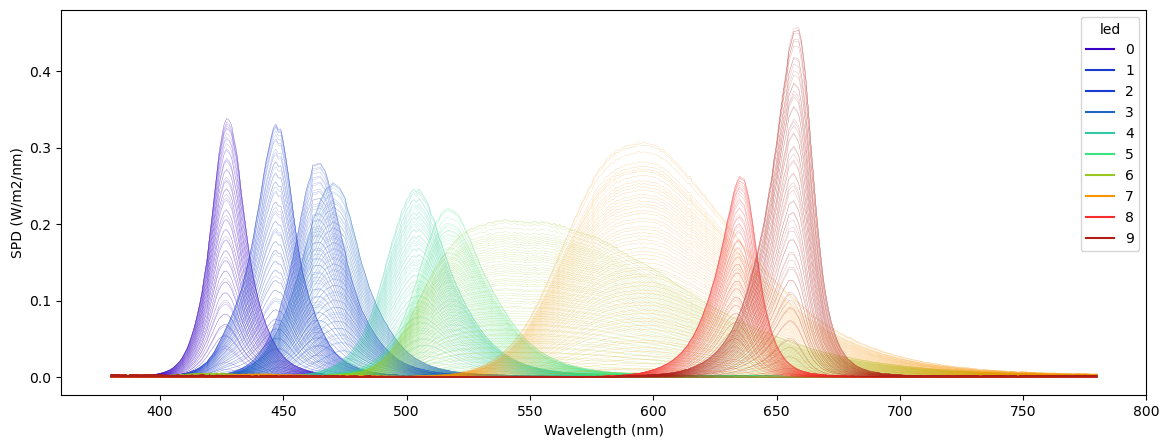

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


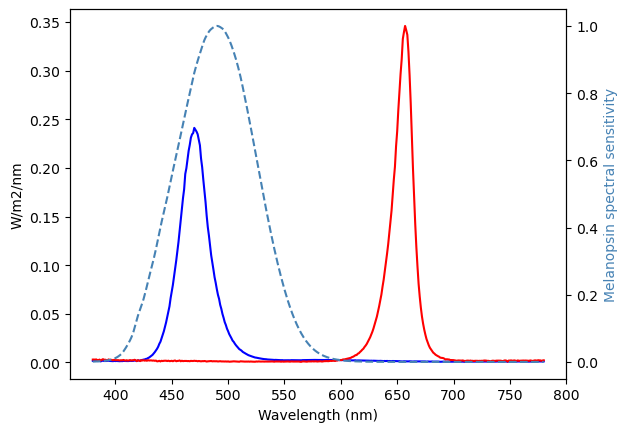

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [8]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [10]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: n


Please enter subject ID: 999
> Grabbing 750 seconds of pupil.1.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 27492.820521
> Waiting for a light to stamp...
> Light stamped on frame.world at 27619.253997
> Waiting for a light to stamp...
> Light stamped on frame.world at 27745.638777
> Waiting for a light to stamp...
> Light stamped on frame.world at 27872.069599
> Waiting for a light to stamp...
> Light stamped on frame.world at 27998.503026
> Waiting for a light to stamp...
> Light stamped on frame.world at 28124.955983
> PupilGrabber done grabbing 750 seconds of pupil.1.3d


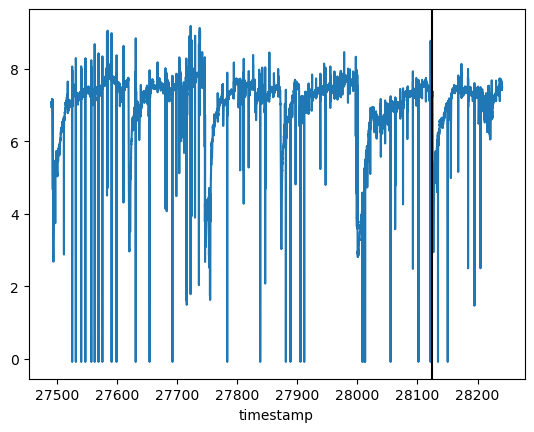

In [11]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 120 # interstimulus time, in seconds
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials # appropriate offset to account for stim duration + sleeps (removed + 30)


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')

In [12]:
# display data from pandas table
data

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
27490.756426,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.38991328184257407, 0.7745468375620275]",49.771664,1.000000,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.998259759543254, -7.73437336161...",6.942973,"{'center': [74.86335011377422, 43.287007188090...","[74.86335011377422, 43.28700718809072]",1.0,2.267539,-2.112374
27490.778501,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.39024977823768275, 0.7742693211203715]",49.843035,1.000000,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.988700626265617, -7.72575815712...",6.953033,"{'center': [74.92795742163509, 43.340290344888...","[74.92795742163509, 43.34029034488867]",1.0,2.266458,-2.110434
27490.801088,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.39191141418207626, 0.7763385718739423]",49.909035,1.000000,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.9431299669336726, -7.7869154447...",6.964831,"{'center': [75.24699152295864, 42.942994200203...","[75.24699152295864, 42.94299420020308]",1.0,2.274149,-2.107623
27490.813968,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3924428435706508, 0.7775329323016762]",49.969878,1.000000,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.929115298034067, -7.82303973856...",6.975657,"{'center': [75.34902596556495, 42.713676998078...","[75.34902596556495, 42.71367699807818]",1.0,2.278716,-2.107877
27490.837637,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.39494035295779967, 0.7807689882094093]",49.741773,1.000000,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.859484581497521, -7.91743969947...",6.943519,"{'center': [75.82854776789753, 42.092354263793...","[75.82854776789753, 42.09235426379341]",1.0,2.290735,-2.103743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28240.694228,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3938201256997392, 0.8031842387848297]",52.854955,0.971745,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.922695527341366, -8.63640074616...",7.475092,"{'center': [75.61346413434993, 37.788626153312...","[75.61346413434993, 37.788626153312705]",1.0,2.386956,-2.173066
28240.711641,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3938051567002687, 0.8030395919326323]",52.707662,0.995639,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.9223860477340615, -8.6309137351...",7.451321,"{'center': [75.6105900864516, 37.8163983489345...","[75.6105900864516, 37.81639834893459]",1.0,2.386185,-2.172450
28240.732079,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.39347892427921916, 0.8029696175528133]",52.983219,1.000000,"{'center': [1.1103068632018367, -1.06539613348...","{'center': [101.92957814395055, 90.08553081138...","{'center': [-2.9329068314716027, -8.6310007496...",7.495534,"{'center': [75.54795346161008, 37.829833429859...","[75.54795346161008, 37.829833429859846]",1.0,2.386197,-2.174252


In [13]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data.to_csv(path_base + subj_base + '.csv')

**DATA PROCESSING BEGINS BELOW**

In [14]:
new_data = data[['confidence','id','diameter','diameter_3d']]

In [16]:
samples = new_data
samples

,confidence,id,diameter,diameter_3d
timestamp,,,,
27490.756426,1.000000,1,49.771664,6.942973
27490.778501,1.000000,1,49.843035,6.953033
27490.801088,1.000000,1,49.909035,6.964831
27490.813968,1.000000,1,49.969878,6.975657
27490.837637,1.000000,1,49.741773,6.943519
...,...,...,...,...
28240.694228,0.971745,1,52.854955,7.475092
28240.711641,0.995639,1,52.707662,7.451321
28240.732079,1.000000,1,52.983219,7.495534


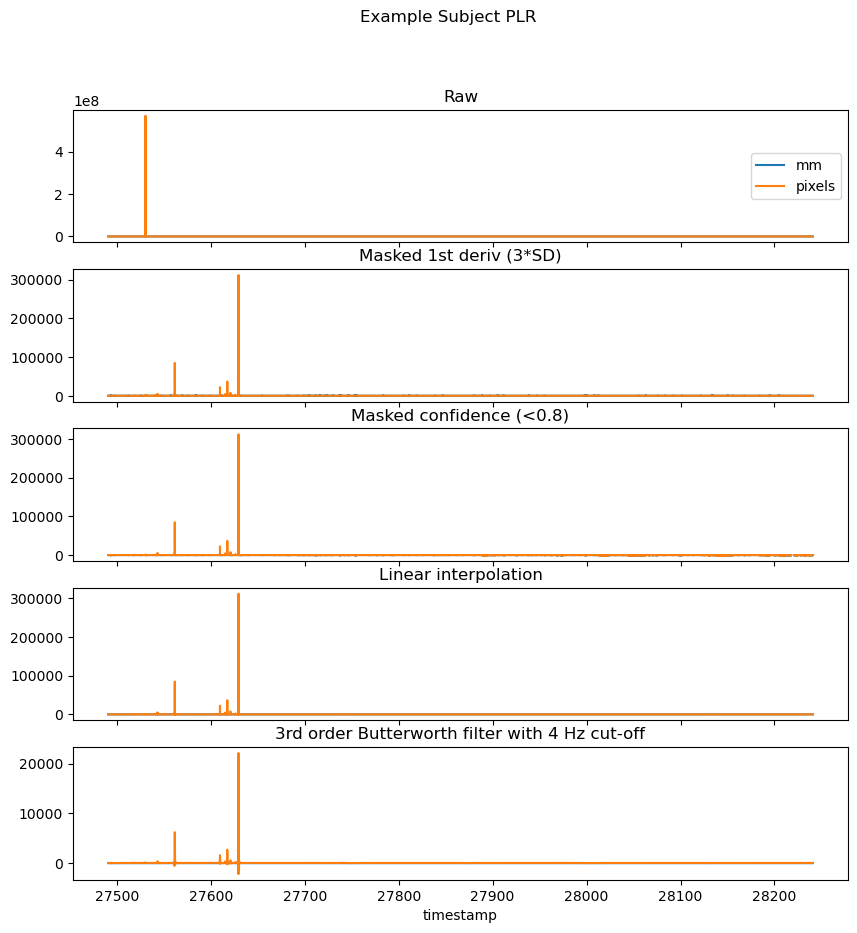

In [17]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
# Read in csv file and extract the column with header "CVR"
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr = pd.read_csv(path_base + subj_base + '.csv')

# Print header names
print(df_pipr.columns)

# Extract the column with header "CVR"
timestamps = df_pipr["timestamp"]
# Extract the column with header "CVR_SI"
diam_3d = df_pipr["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi'],
      dtype='object')


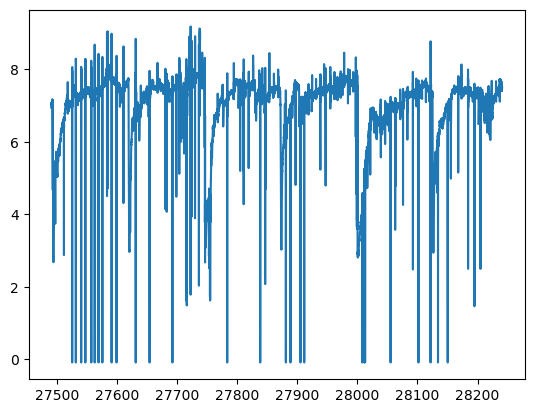

In [20]:
fig = plt.figure()
plt.plot(timestamps, diam_3d)

This is copied from the output of cell 11
> Light stamped on frame.world at 689970.0772810001
> Waiting for a light to stamp...
> Light stamped on frame.world at 690036.3856500001
> Waiting for a light to stamp...
> Light stamped on frame.world at 690102.918729
> Waiting for a light to stamp...
> Light stamped on frame.world at 690169.428877
> Waiting for a light to stamp...
> Light stamped on frame.world at 690235.923252
> Waiting for a light to stamp...
> Light stamped on frame.world at 690302.5674930001

**Edit Cell Below with Timestamps**

In [31]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps <= 27492.820521)[0][-1]
stamp2 = np.where(timestamps <= 27619.253997)[0][-1]
stamp3 = np.where(timestamps <= 27745.638777)[0][-1]
stamp4 = np.where(timestamps <= 27872.069599)[0][-1]
stamp5 = np.where(timestamps <= 27998.503026)[0][-1]
stamp6 = np.where(timestamps <= 28124.955983)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[103, 6661, 13088, 19419, 25730, 32022]

In [32]:
from pyplr import utils
from copy import deepcopy

In [33]:
df_data = df_pipr[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data

,timestamp,confidence,id,diameter,diameter_3d
0,27490.756426,1.000000,1,49.771664,6.942973
1,27490.778501,1.000000,1,49.843035,6.953033
2,27490.801088,1.000000,1,49.909035,6.964831
3,27490.813968,1.000000,1,49.969878,6.975657
4,27490.837637,1.000000,1,49.741773,6.943519
...,...,...,...,...,...
37890,28240.694228,0.971745,1,52.854955,7.475092
37891,28240.711641,0.995639,1,52.707662,7.451321
37892,28240.732079,1.000000,1,52.983219,7.495534
37893,28240.747334,0.923064,1,52.958450,7.493549


**Extract ranges from samples based on event timing and sample count**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [34]:
samples = df_data
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples.index, event_starts, "left") + offset
)
range_duration = duration


In [35]:
range_idxs

array([   43,  6601, 13028, 19359, 25670, 31962], dtype=int64)

In [36]:
# make a hierarchical index
samples["orig_idx"] = samples.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples):
        end_idx = len(samples) - 1
    new_df = deepcopy(
        samples.loc[samples.index[start_idx] : samples.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df = pd.concat([df, new_df])
    idx += 1
df.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_15916\2016008756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["orig_idx"] = samples.index


In [37]:
df.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data**

In [38]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines = df.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df = preproc.percent_signal_change(
    df, baselines, ['diameter_3d', 'diameter'])
df


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_15916\2404135914.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = df.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0      27491.587480    0.968767   1  50.218322     7.082363        43   
      1      27491.605844    0.923570   1  49.973788     7.042831        44   
      2      27491.629817    0.944362   1  50.191207     7.077581        45   
      3      27491.652968    0.991496   1  49.879545     7.028923        46   
      4      27491.674065    0.966023   1  50.219356     7.082651        47   
...                   ...         ...  ..        ...          ...       ...   
5     3595   28193.601622    0.817218   1  51.119763     7.213566     35557   
      3596   28193.617102    0.863312   1  51.128936     7.215365     35558   
      3597   28193.638355    0.889966   1  51.150608     7.218331     35559   
      3598   28193.673888    0.864598   1  51.154790     7.219159     35560   
      3599   28193.694585    0.842920   1  51.087496     7.208762     35561   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.169640    -0.149507  
      1           -0.726867    -0.635720  
      2           -0.237044    -0.203420  
      3           -0.922906    -0.823106  
      4           -0.165581    -0.147450  
...                     ...          ...  
5     3595        -1.322633    -0.990157  
      3596        -1.298026    -0.972390  
      3597        -1.257461    -0.930415  
      3598        -1.246127    -0.922316  
      3599        -1.388355    -1.052653  

[21600 rows x 8 columns]

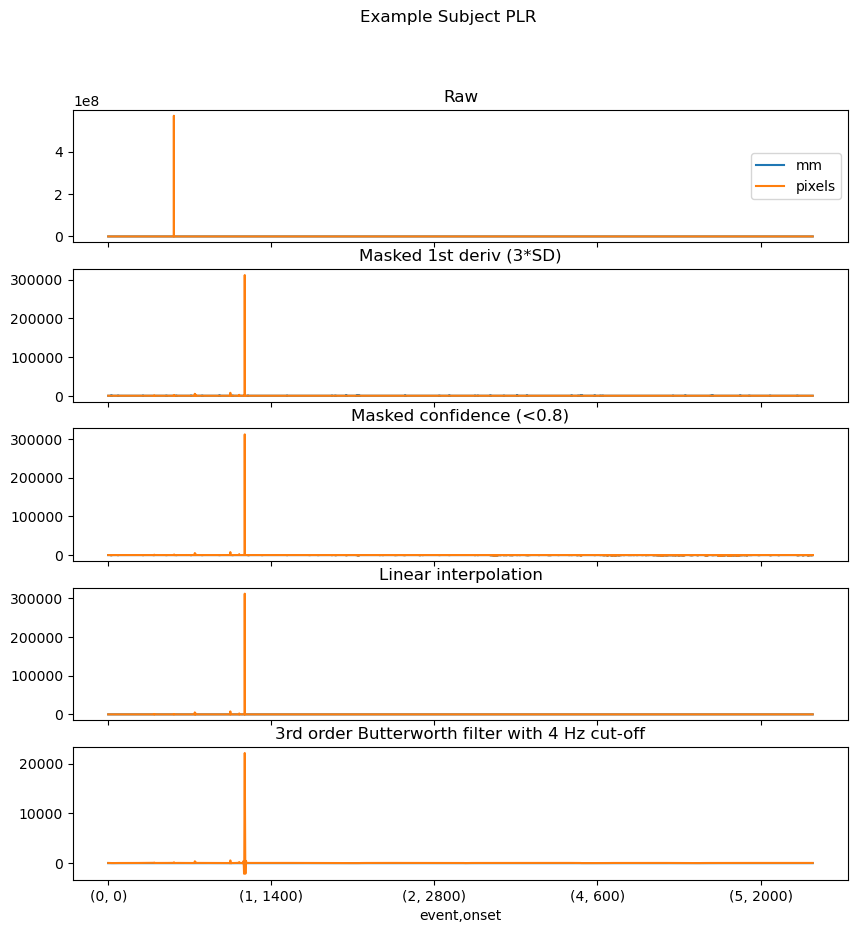

In [39]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples = df

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [40]:
samples # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0      27491.587480    0.968767   1  50.221451     7.082834        43   
      1      27491.605844    0.923570   1  50.204320     7.079738        44   
      2      27491.629817    0.944362   1  50.187239     7.076647        45   
      3      27491.652968    0.991496   1  50.170680     7.073637        46   
      4      27491.674065    0.966023   1  50.155061     7.070778        47   
...                   ...         ...  ..        ...          ...       ...   
5     3595   28193.601622    0.817218   1  51.163632     7.220523     35557   
      3596   28193.617102    0.863312   1  51.146019     7.217789     35558   
      3597   28193.638355    0.889966   1  51.129098     7.215165     35559   
      3598   28193.673888    0.864598   1  51.113156     7.212694     35560   
      3599   28193.694585    0.842920   1  51.098459     7.210419     35561   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           -0.169640    -0.149507             0  
      1           -0.726867    -0.635720             0  
      2           -0.237044    -0.203420             0  
      3           -0.922906    -0.823106             0  
      4           -0.165581    -0.147450             0  
...                     ...          ...           ...  
5     3595        -1.322633    -0.990157             0  
      3596        -1.298026    -0.972390             0  
      3597        -1.257461    -0.930415             0  
      3598        -1.246127    -0.922316             0  
      3599        -1.388355    -1.052653             0  

[21600 rows x 9 columns]

In [41]:
df

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0      27491.587480    0.968767   1  50.218322     7.082363        43   
      1      27491.605844    0.923570   1  49.973788     7.042831        44   
      2      27491.629817    0.944362   1  50.191207     7.077581        45   
      3      27491.652968    0.991496   1  49.879545     7.028923        46   
      4      27491.674065    0.966023   1  50.219356     7.082651        47   
...                   ...         ...  ..        ...          ...       ...   
5     3595   28193.601622    0.817218   1  51.119763     7.213566     35557   
      3596   28193.617102    0.863312   1  51.128936     7.215365     35558   
      3597   28193.638355    0.889966   1  51.150608     7.218331     35559   
      3598   28193.673888    0.864598   1  51.154790     7.219159     35560   
      3599   28193.694585    0.842920   1  51.087496     7.208762     35561   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.169640    -0.149507  
      1           -0.726867    -0.635720  
      2           -0.237044    -0.203420  
      3           -0.922906    -0.823106  
      4           -0.165581    -0.147450  
...                     ...          ...  
5     3595        -1.322633    -0.990157  
      3596        -1.298026    -0.972390  
      3597        -1.257461    -0.930415  
      3598        -1.246127    -0.922316  
      3599        -1.388355    -1.052653  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [42]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df.index = df.index.set_levels(
    levels=new_onset, level='onset')

In [43]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc'],
      dtype='object')

In [44]:
df["colour"] = ""

In [45]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc', 'colour'],
      dtype='object')

In [46]:
for (event, onset) in df.index:
    if event%2==1:
        df["colour"][event,onset] = "red"
    else:
        df["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_15916\884742854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_15916\884742854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 1')

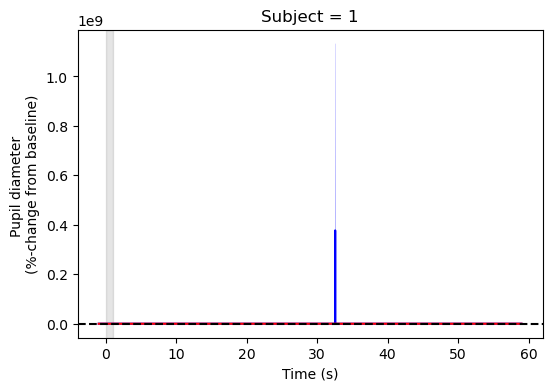

In [47]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs = (df.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df['id'][0][0]))

In [44]:
df # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   689969.012534    0.999656   1  61.996480     6.868490   
      -0.983333   689969.031796    0.999904   1  61.923981     6.857779   
      -0.966667   689969.050745    0.983989   1  62.029771     6.870434   
      -0.950000   689969.063570    0.942364   1  61.933063     6.859060   
      -0.933333   689969.082726    0.950674   1  62.184343     6.889556   
...                         ...         ...  ..        ...          ...   
5      58.916667  690379.523805    0.966725   1  68.223894     7.612237   
       58.933333  690379.540857    0.941435   1  68.186522     7.607425   
       58.950000  690379.562533    0.994952   1  68.216086     7.611046   
       58.966667  690379.584044    0.944150   1  68.028559     7.587172   
       58.983333  690379.604336    0.957176   1  68.196947     7.607872   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         57       -0.939540    -0.864253   blue  
      -0.983333         58       -1.094010    -0.980183   blue  
      -0.966667         59       -0.911495    -0.811019   blue  
      -0.950000         60       -1.075545    -0.965660   blue  
      -0.933333         61       -0.635711    -0.563849   blue  
...                    ...             ...          ...    ...  
5      58.916667     21073        5.481062     4.908184    red  
       58.933333     21074        5.414393     4.850716    red  
       58.950000     21075        5.464563     4.896178    red  
       58.966667     21076        5.133746     4.607817    red  
       58.983333     21077        5.420584     4.866747    red  

[21600 rows x 9 columns]

In [45]:
df.to_csv(path_base + subj_base + '-processed.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

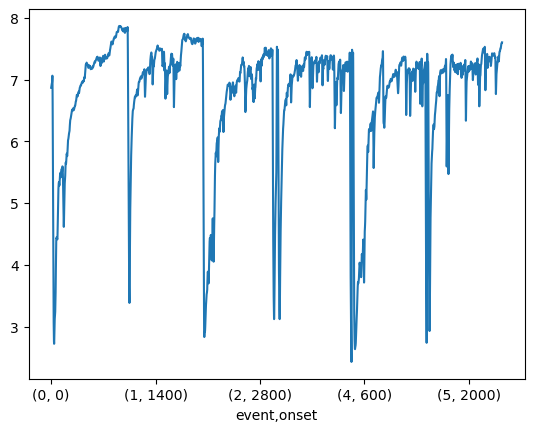

In [47]:
samples["diameter_3d"].plot()

**Compute the pupillary light response:**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params